In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%cd ..
from libs import utils as utils

sns.set_color_codes("muted")


/Users/wuxiaopan/work/DataScience/Exercise


In [51]:
%cd ./SentimentAnalysis
%pwd

/Users/wuxiaopan/work/DataScience/Exercise/SentimentAnalysis


'/Users/wuxiaopan/work/DataScience/Exercise/SentimentAnalysis'

# 1. Load the data

- https://www.kaggle.com/atulanandjha/imdb-50k-movie-reviews-test-your-bert

- https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained#7.-LSTM


In [3]:
!kaggle datasets download -d atulanandjha/imdb-50k-movie-reviews-test-your-bert -p data

!unzip data/imdb-50k-movie-reviews-test-your-bert -d data


100%|██████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 26.0MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 27.2MB/s]
Archive:  data/imdb-50k-movie-reviews-test-your-bert.zip
  inflating: data/test.csv           
  inflating: data/train.csv          


# 2. Identify variables

In [52]:
df = pd.read_csv('./data/train.csv')


In [53]:
df.shape


(25000, 2)

In [54]:
df.head()


,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [55]:
df = utils.check_duplicated(df)


96 duplicated rows!
Remove duplicates...
No duplicated rows!


In [56]:
utils.missing_table(df)


No missing values!


## Class Distribution

pos    12472
neg    12432
Name: sentiment, dtype: int64

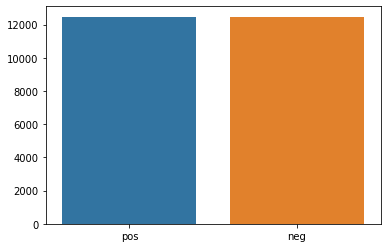

In [57]:
label_counts = df_reviews['sentiment'].value_counts()

sns.barplot(x=label_counts.index, y=label_counts.values)

label_counts


## Word Cloud

In [243]:
from wordcloud import WordCloud

def plot_word_cloud(text, size=(8, 8)):
    wordcloud = WordCloud(
        background_color = 'white',
        random_state = 42
    ).generate(text)

    plt.figure( figsize=size )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
def plot_confuse_matrix(conf_matrix, size=(6, 4)):
    fig, ax = plt.subplots(figsize=size)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    
    sns.heatmap(
        [[tp, fp], [fn, tn]], 
        annot=True, annot_kws={"size": 14}, fmt='g',
        xticklabels=['Positive', 'Negative'],
        yticklabels=['Positive', 'Negative']
    )

    # ax.set_title('Confusion matrix',  )
    ax.set_xlabel('Real value', fontsize=14)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Predicted value', fontsize=14)

    plt.show()

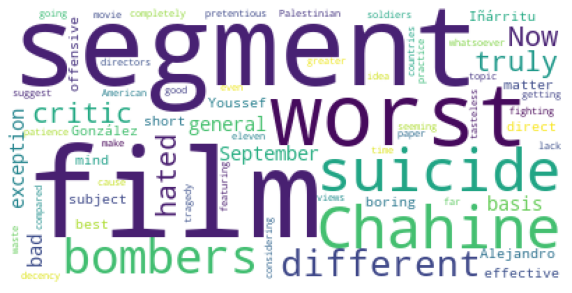

In [59]:
plot_word_cloud(df.iat[22, 0], size=(10, 10))


# 3. Text Preprocessing

## Cleaning

- lower the text string
 
 
- tokenization, split text into a smaller unit
  - sentence-level
  - word-level
 

- remove useless elements
    - punctuation
     - 'string' module

    - stop words such as 'a', 'of'
        - built-in set of stop words in NLTK

    - Special symbols, '<, @, \$'
        - customized rules
    
    - empty unit
        - len(token)
    
    - maybe hyperlink
    


- POS, https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    - J, Adjective
    - R, Adverb
    - N, Noun
    - V, Verb

- stemming(too simple) and lemmatization(with context and morphological analysis)
    - normalize a word into its 'root' form
  
 

In [60]:
import string, re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuxiaopan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wuxiaopan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [61]:

def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ

    elif tag.startswith("R"):
        return wordnet.ADV
    
    elif tag.startswith("V"): 
        return wordnet.VERB
    
    else:
        return wordnet.NOUN


digit = re.compile(r'[0-9]+')
text_br = re.compile(r'<br\s*/><br\s*/>>*|(\-)|(\\)|(\/)')
text_line_end = re.compile(r'\n')

stop_words_en = stopwords.words('english')
lem = WordNetLemmatizer()

def clean_sentence(text):
    # lower
    text = text.lower()
   
    text = digit.sub('', text)
    text = text_br.sub('', text)
    text = text_line_end.sub(r' ',text)
    text = text.translate(str.maketrans('','',string.punctuation))

    # tokenization, [a, went, c, ...]
    tokens = word_tokenize(text) # text.split(' ') # naive methods, e.g. New York will be splitted into ['New', 'York']
    
    # remove noise from data
    tokens = [ w for w in tokens if w not in stop_words_en ]
    tokens = [ w for w in tokens if len(w) > 1 ]

    # pos tagging, [(a, 'NN'), (went, 'VB'), (c, 'NN')]
    tokens = pos_tag(tokens)

    # lemmatize, [a, go, c, ...]
    tokens = [ lem.lemmatize(w, get_wordnet_pos(tag)) for w, tag in tokens ]

    return ' '.join(tokens)


In [62]:
df['cleaned_text'] = df['text'].map(lambda t: clean_sentence(t))

df.head()


,text,sentiment,cleaned_text
0,"Now, I won't deny that when I purchased this o...",neg,wont deny purchase ebay high expectation incre...
1,"The saddest thing about this ""tribute"" is that...",neg,sad thing tribute almost singer include otherw...
2,Last night I decided to watch the prequel or s...,neg,last night decide watch prequel shall say call...
3,I have to admit that i liked the first half of...,neg,admit like first half sleeper look good act ev...
4,I was not impressed about this film especially...,neg,impressed film especially fact go cinema famil...


In [71]:
df['clean_text_len'] = df['cleaned_text'].apply(len)

df['text_len'] = df['text'].apply(len)

df.head()


,text,sentiment,cleaned_text,clean_text_len,text_len
0,"Now, I won't deny that when I purchased this o...",neg,wont deny purchase ebay high expectation incre...,392,719
1,"The saddest thing about this ""tribute"" is that...",neg,sad thing tribute almost singer include otherw...,1099,1857
2,Last night I decided to watch the prequel or s...,neg,last night decide watch prequel shall say call...,561,945
3,I have to admit that i liked the first half of...,neg,admit like first half sleeper look good act ev...,510,913
4,I was not impressed about this film especially...,neg,impressed film especially fact go cinema famil...,487,985


<AxesSubplot:xlabel='text_len', ylabel='Count'>

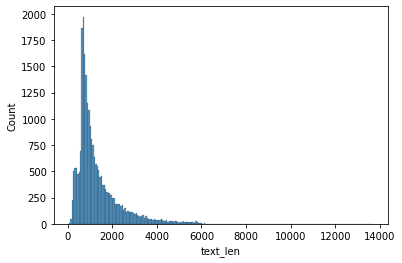

In [72]:

sns.histplot(df['text_len'])


## Target encoding

In [73]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

df['label'] = labelEncoder.fit_transform(df['sentiment'])

df.head()


,text,sentiment,cleaned_text,clean_text_len,text_len,label
0,"Now, I won't deny that when I purchased this o...",neg,wont deny purchase ebay high expectation incre...,392,719,0
1,"The saddest thing about this ""tribute"" is that...",neg,sad thing tribute almost singer include otherw...,1099,1857,0
2,Last night I decided to watch the prequel or s...,neg,last night decide watch prequel shall say call...,561,945,0
3,I have to admit that i liked the first half of...,neg,admit like first half sleeper look good act ev...,510,913,0
4,I was not impressed about this film especially...,neg,impressed film especially fact go cinema famil...,487,985,0


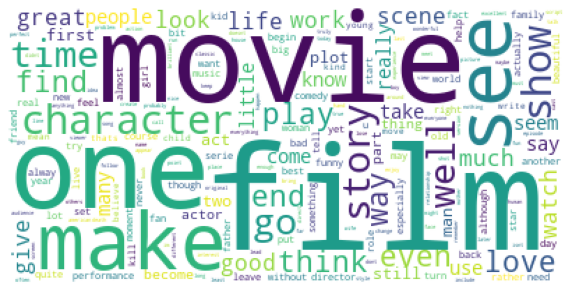

In [67]:
plot_word_cloud(''.join(df.loc[df['label']==1, 'cleaned_text']), size=(10, 10))


# 4. Split train test

In [306]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_raw.shape, X_test_raw.shape, y_train.shape, y_test.shape


((19923,), (4981,), (19923,), (4981,))

# 5. Text Feature extraction

Frequency-based

- BOW
    - doc-term matrix (frequency)
    
- TF-IDF
    - $tf(w_j, d_i) * idf(w_j) = \frac{|w_j|}{|d_i|} \text{log} \frac{|D|}{|D_{w_j}|}$, where
        - $tf(w_j, d_i)$ is the frequency of the word $w_j$ in a doc $d_i$
        - $|D|$ is the total number of documents
        - $|D_{w_j}|$ is the number of documents that contain the word $_j$

Context-based

- CBOW

- Skip gram



In [369]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve, auc
from sklearn.naive_bayes import BernoulliNB, MultinomialNB


### BOW

In [380]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_dtm = vectorizer.fit_transform(X_train_raw)
X_test_dtm = vectorizer.transform(X_test_raw)
print(len(vectorizer.get_feature_names()))

mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)


111095


MultinomialNB()

### Hard 

0.9267178637755358 0.8496285886368199


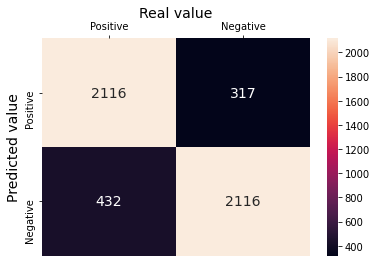

In [381]:
y_train_pred = mnb.predict(X_train_dtm)
y_test_pred = mnb.predict(X_test_dtm)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
plot_confuse_matrix(confusion_matrix(y_test, y_test_pred))


### Soft classification

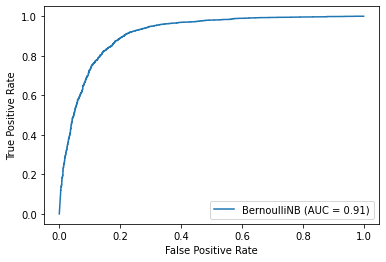

In [382]:

plot_roc_curve(bnb, X_test_dtm, y_test)


## TF-IDF

In [383]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_dtm)
X_test_idf = tfidf.transform(X_test_dtm)

mnb = MultinomialNB()
mnb.fit(X_train_idf, y_train)


MultinomialNB()

### Hard

0.9234051096722381 0.8586629190925517


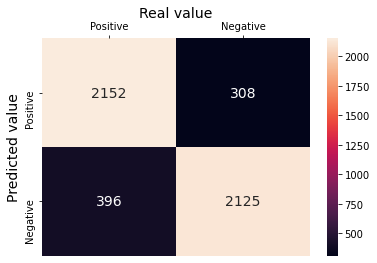

In [384]:
y_train_pred = mnb.predict(X_train_idf)
y_test_pred = mnb.predict(X_test_idf)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
plot_confuse_matrix(confusion_matrix(y_test, y_test_pred))


### Soft

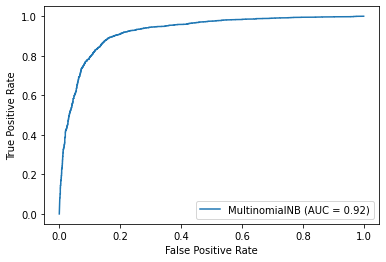

In [385]:

plot_roc_curve(mnb, X_test_dtm, y_test)


# 6. Model Selection

In [389]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


In [390]:
classifiers = {
#     'LinearSVC': LinearSVC(),
    "BernoulliNB": BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
}

def model_selection():
    score_mean, score_std, test_acc, auc = [], [], [], []

    for cls_name, cls_model in classifiers.items():
        pipe = Pipeline([
            ('count', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('classifier', cls_model)
        ])
        
        scores = cross_val_score(pipe, X_train_raw, y_train, cv=3, scoring='accuracy')
        score_mean.append(scores.mean())
        score_std.append(scores.std())
        
        pipe.fit(X_train_raw, y_train)
        y_test_pred = pipe.predict(X_test_raw)

        test_acc.append(accuracy_score(y_test, y_test_pred))
        auc.append(roc_auc_score(y_test, pipe.predict_proba(X_test_raw)[:, 1]))

        print(cls_name, ' done')

    result = pd.DataFrame(
        list(zip(score_mean, score_std, test_acc, auc)), 
        columns=["train_acc_mean", "train_acc_std", 'test_acc', 'auc']
    )
    result["model"] = classifiers.keys()
    print(result)

model_selection()


BernoulliNB  done
MultinomialNB  done
LogisticRegression  done
   train_acc_mean  train_acc_std  test_acc       auc               model
0        0.834212       0.002660  0.826541  0.911915         BernoulliNB
1        0.855745       0.007204  0.858663  0.931341       MultinomialNB
2        0.874718       0.003180  0.883357  0.948275  LogisticRegression


## Voting

In [391]:
voting_cls = VotingClassifier(
    estimators=[ (name, 
                  Pipeline([
                    ('count', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('classifier', model)
                    ])
                 ) 
                for name, model in classifiers.items()], 
    voting='hard'
)
voting_cls = voting_cls.fit(X_train_raw, y_train)
y_train_pred = voting_cls.predict(X_train_raw)

y_test_pred = voting_cls.predict(X_test_raw)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)


(0.9324398935903228, 0.8628789399718932)

# 7. Grid Search

In [392]:
param_grid = {
    'tfidf__use_idf': (True, False),
    'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (15000, 30000, 60000, 90000, 10000)
}


full_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

grid_search = GridSearchCV(
    full_pipeline, param_grid, cv=5,
    scoring='accuracy', return_train_score=False
)
grid_search.fit(X_train_raw, y_train)


print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


print("Test accuracy: ")
y_test_pred = grid_search.predict(X_test_raw)
accuracy_score(y_test, y_test_pred)


Best parameters set:
	tfidf__use_idf: True
	vect__max_df: 0.5
Test accuracy: 


0.8825537040754868